In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [4]:
YEAR = 252

In [5]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [6]:
data.index.names = ['symbol', 'date']

In [7]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

## select investment universe

In [8]:
data = data[data.dollar_vol_rank<100]

In [39]:
data

volume     dollar_vol  dollar_vol_1m  dollar_vol_rank  \
symbol date                                                                     
AAL    2013-07-25  9851.900173  482021.770518  223614.661574             91.0   
       2013-07-26  7797.700026  386784.252060  234821.351626             83.0   
       2013-07-29  6462.699829  322916.026692  243001.954091             78.0   
       2013-07-30  6091.900156  303913.741002  243122.621493             79.0   
       2013-07-31  9571.100178  481215.006566  256336.659780             75.0   
...                        ...            ...            ...              ...   
ZTS    2014-11-28  1332.156000   58600.308107  294715.115434             90.0   
       2014-12-01  3153.115000  136973.841193  297525.671580             92.0   
       2014-12-02  2500.597000  109533.781479  298272.515355             88.0   
       2014-12-03  2008.310000   88245.383471  295315.035852             87.0   
       2014-12-04  4294.633000  185006.560464  286390.276661             95.0   

                         rsi   bb_high    bb_low       atr      macd  \
symbol date                                                            
AAL    2013-07-25  69.669475  0.011251  0.140777 -0.383445  0.681257   
       2013-07-26  72.045207  0.007052  0.146370 -0.412740  0.772848   
       2013-07-29  73.259776  0.008843  0.146963 -0.494894  0.854980   
       2013-07-30  72.532538  0.018500  0.142355 -0.565684  0.904814   
       2013-07-31  73.926238  0.016465  0.139949 -0.653399  0.954135   
...                      ...       ...       ...       ...       ...   
ZTS    2014-11-28  71.884144  0.043559  0.157493  0.397024  2.806829   
       2014-12-01  67.137279  0.051976  0.131103  0.403122  2.691178   
       2014-12-02  68.612084  0.041573  0.120638  0.323857  2.615256   
       2014-12-03  69.175766  0.038192  0.111125  0.236555  2.540352   
       2014-12-04  61.677853  0.051743  0.080568  0.273293  2.329735   

                   return_1d  ...  consumer_durables  consumer_non-durables  \
symbol date                   ...                                             
AAL    2013-07-25   0.017838  ...                  0                      0   
       2013-07-26   0.013808  ...                  0                      0   
       2013-07-29   0.007334  ...                  0                      0   
       2013-07-30  -0.001560  ...                  0                      0   
       2013-07-31   0.007813  ...                  0                      0   
...                      ...  ...                ...                    ...   
ZTS    2014-11-28   0.005820  ...                  0                      0   
       2014-12-01  -0.012464  ...                  0                      0   
       2014-12-02   0.008339  ...                  0                      0   
       2014-12-03   0.003129  ...                  0                      0   
       2014-12-04  -0.019608  ...                  0                      0   

                   consumer_services  energy  finance  health_care  \
symbol date                                                          
AAL    2013-07-25                  0       0        0            0   
       2013-07-26                  0       0        0            0   
       2013-07-29                  0       0        0            0   
       2013-07-30                  0       0        0            0   
       2013-07-31                  0       0        0            0   
...                              ...     ...      ...          ...   
ZTS    2014-11-28                  0       0        0            1   
       2014-12-01                  0       0        0            1   
       2014-12-02                  0       0        0            1   
       2014-12-03                  0       0        0            1   
       2014-12-04                  0       0        0            1   

                   miscellaneous  public_utilities  technology  transportation  
symbol date  

In [10]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [53]:
y.index.get_level_values('symbol').unique()

Index(['AAL', 'AAOI', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADP',
       'ADS',
       ...
       'WLL', 'WMB', 'WMT', 'WY', 'WYNN', 'X', 'XOM', 'YELP', 'YUM', 'ZTS'],
      dtype='object', name='symbol', length=297)

In [55]:
X.columns()

Index(['dollar_vol_1m', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd', 'return_1d',
       'return_5d', 'return_10d', 'return_21d', 'return_42d', 'return_63d',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'capital_goods', 'consumer_non-durables', 'consumer_services', 'energy',
       'finance', 'health_care', 'miscellaneous', 'public_utilities',
       'technology', 'transportation'],
      dtype='object')

## custom MultipleTimeSeriesCV

In [12]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [13]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [14]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


In [15]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

In [16]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

In [17]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

## Linear Regression with sklearn

In [71]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [72]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: total: 1.67 s
Wall time: 1.76 s


In [79]:
lr.coef_

array([-2.35828394e-11,  1.15992872e-04, -1.53254381e-02,  2.61294102e-02,
        3.66126809e-04, -2.44979367e-03, -2.23773092e-02, -1.54363979e-01,
       -6.50852104e-02, -1.52395130e-01, -5.75075285e-01,  1.10416204e+00,
       -2.86576318e-15, -5.62744296e-14, -1.99978922e-14,  3.35842465e-15,
        2.26103858e-14, -2.10942375e-15, -1.77635684e-15, -1.60466855e-03,
        4.25228534e-04,  4.56576777e-04,  7.22863242e-04,  3.77184423e-03,
        6.30156626e-03,  4.50357529e-03, -3.87935105e-04,  5.45265809e-03,
        6.37403307e-03,  6.51117940e-03,  4.81869878e-03,  3.70710734e-03,
        7.91822117e-03])

In [80]:
X_train

dollar_vol_1m        rsi   bb_high    bb_low       atr  \
symbol date                                                                 
AAL    2014-09-10  305626.911161  46.350258  0.055523  0.027481 -0.682851   
       2014-09-11  312564.095831  43.732211  0.066839  0.015379 -0.698950   
       2014-09-12  316004.854291  41.467195  0.077338  0.009672 -0.761163   
       2014-09-15  311099.025793  38.627167  0.092342  0.002590 -0.802492   
       2014-09-16  305131.212403  44.992722  0.066908  0.026947 -0.791550   
...                          ...        ...       ...       ...       ...   
ZTS    2014-11-28  294715.115434  71.884144  0.043559  0.157493  0.397024   
       2014-12-01  297525.671580  67.137279  0.051976  0.131103  0.403122   
       2014-12-02  298272.515355  68.612084  0.041573  0.120638  0.323857   
       2014-12-03  295315.035852  69.175766  0.038192  0.111125  0.236555   
       2014-12-04  286390.276661  61.677853  0.051743  0.080568  0.273293   

                       macd  return_1d  return_5d  return_10d  return_21d  \
symbol date                                                                 
AAL    2014-09-10 -0.317675   0.016333  -0.002878   -0.001312    0.000759   
       2014-09-11 -0.332007  -0.012701  -0.001983   -0.002333    0.000718   
       2014-09-12 -0.363179  -0.011552  -0.001059   -0.003950   -0.000591   
       2014-09-15 -0.414564  -0.015405  -0.006144   -0.004758   -0.003103   
       2014-09-16 -0.402699   0.024548   0.000105   -0.006404   -0.001492   
...                     ...        ...        ...         ...         ...   
ZTS    2014-11-28  2.806829   0.005820   0.008117    0.003841    0.009878   
       2014-12-01  2.691178  -0.012464   0.002269    0.002815    0.008365   
       2014-12-02  2.615256   0.008339   0.000717    0.001147    0.009064   
       2014-12-03  2.540352   0.003129   0.004380    0.001551    0.008311   
       2014-12-04  2.329735  -0.019608  -0.003018    0.001374    0.005614   

                   ...  capital_goods  consumer_non-durables  \
symbol date        ...                                         
AAL    2014-09-10  ...              0                      0   
       2014-09-11  ...              0                      0   
       2014-09-12  ...              0                      0   
       2014-09-15  ...              0                      0   
       2014-09-16  ...              0                      0   
...                ...            ...                    ...   
ZTS    2014-11-28  ...              0                      0   
       2014-12-01  ...              0                      0   
       2014-12-02  ...              0                      0   
       2014-12-03  ...              0                      0   
       2014-12-04  ...              0                      0   

                   consumer_services  energy  finance  health_care  \
symbol date                                                          
AAL    2014-09-10                  0       0        0            0   
       2014-09-11                  0       0        0            0   
       2014-09-12                  0       0        0            0   
       2014-09-15                  0       0        0            0   
       2014-09-16                  0       0        0            0   
...                              ...     ...      ...          ...   
ZTS    2014-11-28                  0       0        0            1   
       2014-12-01                  0       0        0            1   
       2014-12-02                  0       0        0            1   
       2014-12-03                  0       0        0            1   
       2014-12-04                  0       0        0            1   

                   miscellaneous  public_utilities  technology  transportation  
symbol date                                                                     
AAL    2014-09-10              0                 0           0               1  
       2014-09-11           

In [21]:
lr_scores.to_hdf('data.h5', 'lr/scores')
lr_predictions.to_hdf('data.h5', 'lr/predictions')

In [22]:
lr_scores = pd.read_hdf('data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('data.h5', 'lr/predictions')

In [23]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 1.531% (p-value: 0.0031%)


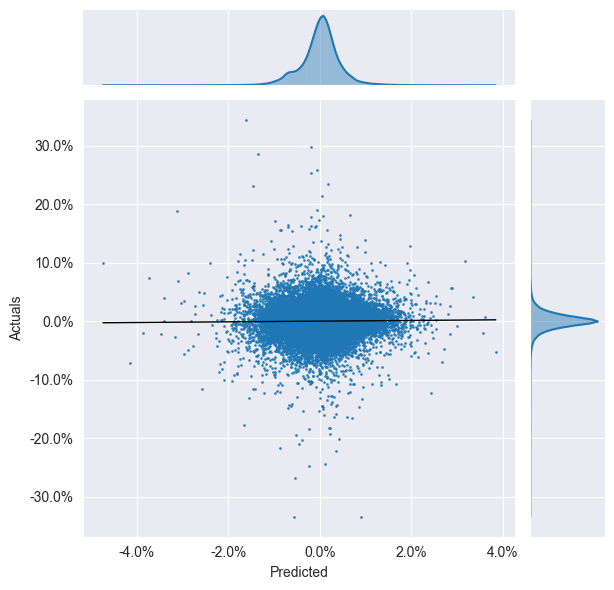

In [24]:
plot_preds_scatter(lr_predictions)

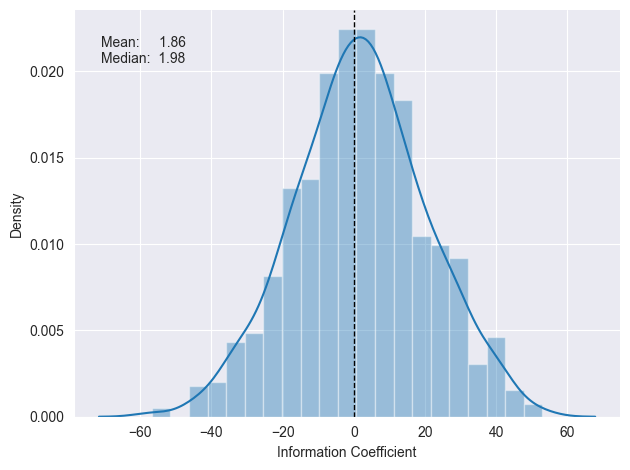

In [25]:
plot_ic_distribution(lr_scores)

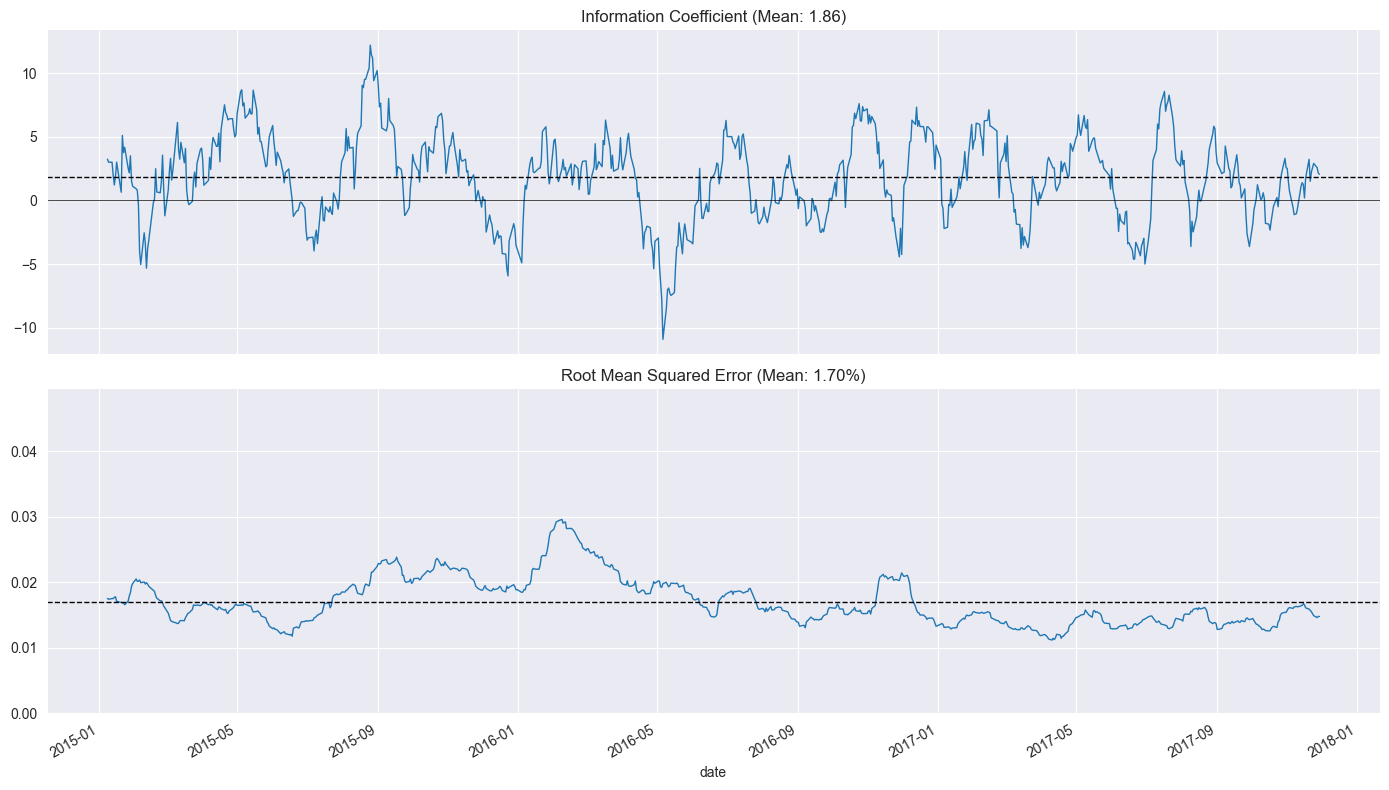

In [26]:
plot_rolling_ic(lr_scores)

## Ridge Regression

In [27]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [28]:
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [29]:
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [81]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: total: 31.5 s
Wall time: 32.5 s


In [86]:
coeffs[0]

array([-1.71077234e-06,  2.66723093e-05, -2.81125602e-05,  5.24962669e-08,
        1.47274740e-05, -1.73000808e-06,  6.49702025e-05,  9.57389727e-06,
        1.16689295e-06,  1.71794251e-05, -6.48385587e-06,  1.98221383e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.50008594e-06,  4.19057596e-05,
        9.48893646e-07, -5.54900353e-05,  0.00000000e+00,  1.76592634e-05,
       -2.39845759e-05, -1.58412200e-05, -4.15389693e-05,  1.51778120e-05,
       -3.94189285e-05,  1.67206006e-05, -2.89686030e-05,  6.26526076e-05,
        5.04212321e-06])

In [69]:
spearmanr(preds['predicted'],preds['actuals'])[0]

-0.013356207996416096

In [67]:
y_pred

array([ 5.82525889e-04,  6.55808314e-04,  7.17549534e-04,  6.35622202e-04,
        6.81292002e-04,  5.46408703e-04,  6.27876838e-04,  6.93629130e-04,
        6.83213341e-04,  6.49440680e-04,  1.14436108e-04,  4.55223001e-05,
        5.41540536e-05,  2.84052678e-05,  6.82609230e-05,  7.60517456e-05,
        1.77338822e-04,  2.58529268e-04,  2.16063068e-04,  2.51283230e-04,
        2.50694332e-04,  1.87548674e-04,  1.70420386e-04,  9.63292810e-05,
        1.25842225e-04,  1.07150290e-04,  1.90157254e-04,  2.28279396e-04,
        2.00208492e-04,  1.82058817e-04,  2.70698630e-04,  2.00644637e-04,
        2.31653779e-04,  1.44085650e-04,  1.74430124e-04,  7.99678997e-05,
        1.49477438e-04,  1.76666002e-04,  1.93284589e-04,  1.21829337e-04,
       -7.66522023e-05, -1.15673194e-04, -7.44589082e-05, -1.40387274e-04,
       -1.37200023e-04, -1.52406174e-04, -6.41436990e-05, -2.00077143e-05,
        1.32358852e-05,  2.18094430e-05, -1.24429987e-05,  2.43056708e-05,
       -1.72142135e-05,  

In [31]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data.h5', 'ridge/predictions')

In [32]:
ridge_scores = pd.read_hdf('data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('data.h5', 'ridge/predictions')

In [33]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 1.551% (p-value: 0.0000%)


In [34]:
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0005,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0010,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0050,750.0,1.863890,18.565617,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0100,750.0,1.864012,18.565426,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0500,750.0,1.864657,18.566158,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.1000,750.0,1.864743,18.566752,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.5000,750.0,1.863531,18.566137,-56.835055,-9.996599,1.966605,14.124337,53.034014
1.0000,750.0,1.863910,18.566893,-56.835055,-9.996599,1.966605,14.110091,53.161410


In [35]:
ridge_coeffs

,dollar_vol_1m,rsi,bb_high,bb_low,atr,macd,return_1d,return_5d,return_10d,return_21d,...,capital_goods,consumer_non-durables,consumer_services,energy,finance,health_care,miscellaneous,public_utilities,technology,transportation
0.0001,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630176e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632253e-04
0.0005,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630173e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632249e-04
0.0010,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630168e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632245e-04
0.0050,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630133e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632207e-04
0.0100,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630088e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632160e-04
0.0500,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.629729e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.631786e-04
0.1000,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.629281e-04,0.000266,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.631319e-04
0.5000,0.000072,-0.000027,0.000867,-0.000648,0.000025,-0.001177,0.000134,-0.000324,0.000254,0.000733,...,0.000245,1.625708e-04,0.000266,0.000070,0.000221,0.000245,0.000213,0.000067,0.000413,1.627593e-04
1.0000,0.000072,-0.000028,0.000865,-0.000647,0.000025,-0.001176,0.000134,-0.000324,0.000253,0.000732,...,0.000244,1.621264e-04,0.000265,0.000070,0.000221,0.000244,0.000213,0.000067,0.000413,1.622959e-04
5.0000,0.000072,-0.000035,0.000853,-0.000639,0.000025,-0.001170,0.000134,-0.000324,0.000247,0.000727,...,0.000240,1.586609e-04,0.000260,0.000065,0.000216,0.000238,0.000211,0.000064,0.000407,1.586859e-04


In [36]:
ridge_scores

,ic,rmse,alpha
date,,,
2017-11-15,14.975550,0.020270,0.0001
2017-11-16,-26.598103,0.011859,0.0001
2017-11-17,38.779336,0.010426,0.0001
2017-11-20,35.754771,0.013288,0.0001
2017-11-21,-39.360786,0.009613,0.0001
...,...,...,...
2014-12-16,-26.755720,0.031151,50000.0000
2014-12-17,21.856524,0.028092,50000.0000
2014-12-18,-49.324675,0.020744,50000.0000


ValueError: cannot reindex from a duplicate axis

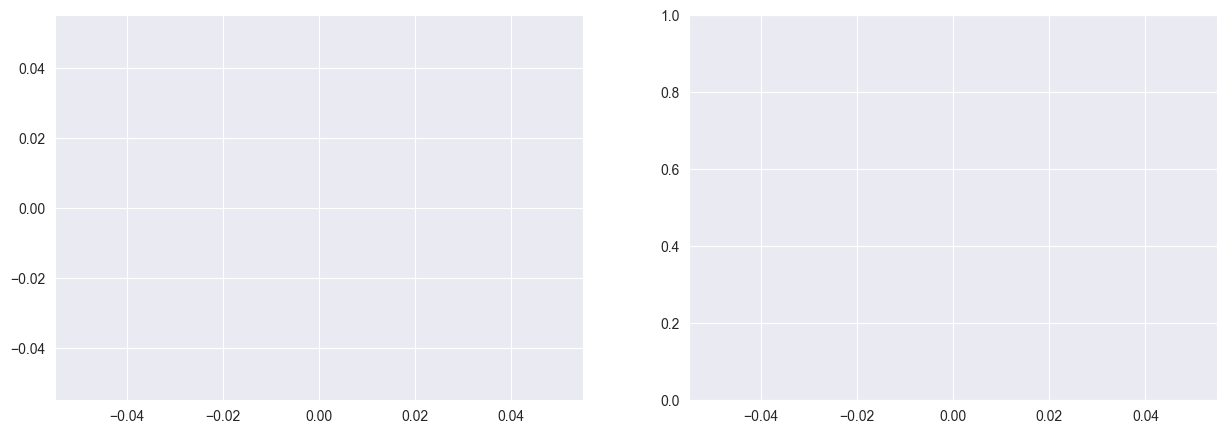

In [37]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

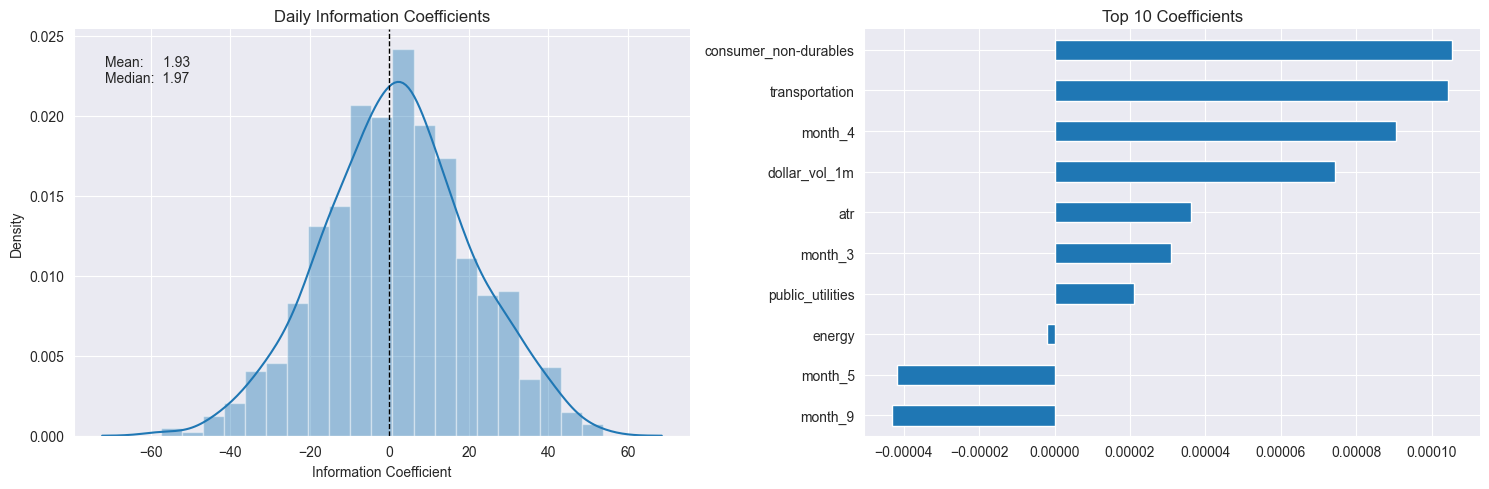

In [38]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

In [58]:
ridge_scores.groupby('alpha').ic.mean()

alpha
0.0001        1.863889
0.0005        1.863889
0.0010        1.863889
0.0050        1.863890
0.0100        1.864012
0.0500        1.864657
0.1000        1.864743
0.5000        1.863531
1.0000        1.863910
5.0000        1.869287
10.0000       1.874358
50.0000       1.901971
100.0000      1.927645
500.0000      1.864157
1000.0000     1.728983
5000.0000     1.370344
10000.0000    1.200334
50000.0000    0.825230
Name: ic, dtype: float64